In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null

In [ ]:
!unzip './drive/MyDrive/Data/archive.zip'

In [ ]:
# Importing necessary libraries and modules
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score
)

from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [ ]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from pathlib import Path
# Define the list of allowed labels
allowed_labels = [
    'Amanita pantherina',
    'Amanita rubescens',
    'Apioperdon pyriforme',
    'Armillaria borealis',
    'Artomyces pyxidatus',
    'Bjerkandera adusta',
    'Boletus edulis',
    'Boletus reticulatus',
    'Calocera viscosa',
    'Calycina citrina',
    'Cantharellus cibarius',
    'Cetraria islandica',
    'Chlorociboria aeruginascens',
    'Chondrostereum purpureum',
    'Cladonia fimbriata',
    'Cladonia rangiferina',
    'Cladonia stellaris',
    'Clitocybe nebularis',
    'Coltricia perennis',
    'Coprinellus disseminatus',
    'Coprinellus micaceus',
    'Coprinopsis atramentaria',
    'Crucibulum laeve',
    'Daedaleopsis confragosa',
    'Daedaleopsis tricolor',
    'Ganoderma applanatum',
    'Graphis scripta',
    'Gyromitra esculenta',
    'Gyromitra infula',
    'Hygrophoropsis aurantiaca'
]

# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Iterate through all image files in the specified directory
for file in sorted(Path('./dataset').glob('*/*.*')):
    # Extract the label from the file path
    label = str(file).split('/')[-2]

    # Check if the label is in the allowed list
    if label in allowed_labels:
        file_names.append(str(file))  # Add the file path to the list
        labels.append(label)  # Add the label to the list

# Print the total number of file names and labels
print(len(file_names), len(labels), len(set(labels)))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})

14460 14460 30


In [ ]:
# random oversampling of all minority classes
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

print(df.shape)

(44070, 2)


In [ ]:
# Create a dataset from a Pandas DataFrame.
dataset = Dataset.from_pandas(df).cast_column("image", Image())

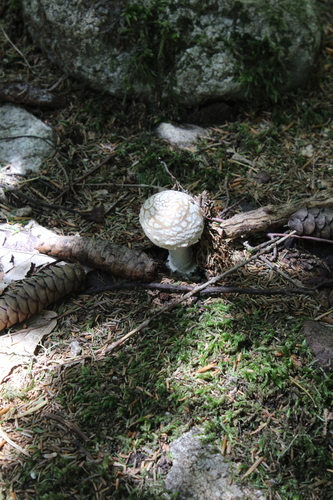

In [ ]:
dataset[1]["image"]

In [ ]:
# Extracting a subset of elements from the 'labels' list using slicing.
# The slicing syntax [:5] selects elements from the beginning up to (but not including) the 5th element.
# This will give us the first 5 elements of the 'labels' list.
# The result will be a new list containing these elements.
labels_subset = labels[:5]

# Printing the subset of labels to inspect the content.
print(labels_subset)

['Amanita pantherina', 'Amanita pantherina', 'Amanita pantherina', 'Amanita pantherina', 'Amanita pantherina']


In [ ]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = [
    'Amanita pantherina',
    'Amanita rubescens',
    'Apioperdon pyriforme',
    'Armillaria borealis',
    'Artomyces pyxidatus',
    'Bjerkandera adusta',
    'Boletus edulis',
    'Boletus reticulatus',
    'Calocera viscosa',
    'Calycina citrina',
    'Cantharellus cibarius',
    'Cetraria islandica',
    'Chlorociboria aeruginascens',
    'Chondrostereum purpureum',
    'Cladonia fimbriata',
    'Cladonia rangiferina',
    'Cladonia stellaris',
    'Clitocybe nebularis',
    'Coltricia perennis',
    'Coprinellus disseminatus',
    'Coprinellus micaceus',
    'Coprinopsis atramentaria',
    'Crucibulum laeve',
    'Daedaleopsis confragosa',
    'Daedaleopsis tricolor',
    'Ganoderma applanatum',
    'Graphis scripta',
    'Gyromitra esculenta',
    'Gyromitra infula',
    'Hygrophoropsis aurantiaca'
] #list(set(labels))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Amanita pantherina', 1: 'Amanita rubescens', 2: 'Apioperdon pyriforme', 3: 'Armillaria borealis', 4: 'Artomyces pyxidatus', 5: 'Bjerkandera adusta', 6: 'Boletus edulis', 7: 'Boletus reticulatus', 8: 'Calocera viscosa', 9: 'Calycina citrina', 10: 'Cantharellus cibarius', 11: 'Cetraria islandica', 12: 'Chlorociboria aeruginascens', 13: 'Chondrostereum purpureum', 14: 'Cladonia fimbriata', 15: 'Cladonia rangiferina', 16: 'Cladonia stellaris', 17: 'Clitocybe nebularis', 18: 'Coltricia perennis', 19: 'Coprinellus disseminatus', 20: 'Coprinellus micaceus', 21: 'Coprinopsis atramentaria', 22: 'Crucibulum laeve', 23: 'Daedaleopsis confragosa', 24: 'Daedaleopsis tricolor', 25: 'Ganoderma applanatum', 26: 'Graphis scripta', 27: 'Gyromitra esculenta', 28: 'Gyromitra infula', 29: 'Hygrophoropsis aurantiaca'} 

Mapping of Labels to IDs: {'Amanita pantherina': 0, 'Amanita rubescens': 1, 'Apioperdon pyriforme': 2, 'Armillaria borealis': 3, 'Artomyces pyxidatus': 4, 'Bje

In [ ]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using an 60-40 split ratio.
dataset = dataset.train_test_split(test_size=0.3, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
train_data = dataset['train']

# Extracting the testing data from the split dataset.
test_data = dataset['test']

Map:   0%|          | 0/44070 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/44070 [00:00<?, ? examples/s]

In [ ]:
# Define the pre-trained ViT model string
model_str = 'google/vit-base-patch16-224-in21k' #'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation up to 20 degrees
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Size:  224


In [ ]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

In [ ]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])

    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.821726


In [ ]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions

    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

In [ ]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "mushrooms_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 1

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,

    # Specify the directory where training logs will be stored.
    logging_dir='./logs',

    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",

    # Set the learning rate for the optimizer.
    learning_rate=2e-7,

    # Define the batch size for training on each device.
    per_device_train_batch_size=32,

    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=8,

    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,

    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,

    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,

    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,

    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',

    # Load the best model at the end of training.
    load_best_model_at_end=True,

    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,

    # Specify that training progress should not be reported.
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)


In [ ]:
outputs = trainer.predict(test_data)

print(outputs.metrics)

In [ ]:
y_true = outputs.label_ids

y_pred = outputs.predictions.argmax(1)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [ ]:
# |trainer.save_model(output_dir='./drive/MyDrive/Data')

In [ ]:
# trainer.tokenizer.save_pretrained("./drive/MyDrive/Data")